In [1]:
#추가적인 파일 다운로드 부분
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 7.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━

In [2]:
# FashionMNIST 데이터를 불러와서 시각화하고 분석한다.
def explore_data(data_loader):
    # 클래스 레이블입니다..
    classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

    # 데이터셋에서 이미지와 레이블을 가져온다.
    images, labels = next(iter(data_loader))
    
    # 이미지를 시각화합니다.
    plt.figure(figsize=(20, 20))
    for i in range(25):
        plt.subplot(10, 10, i + 1)
        plt.imshow(images[i][0], cmap='gray')  # 이미지 플로팅
        plt.title(classes[labels[i]])  # 레이블을 제목으로 설정
        plt.axis('off')  # 축 제거
    plt.show()

    # 클래스별 이미지 수 확인
    class_count = {}
    for _, label in data_loader:  # 각 미니배치에서 레이블을 가져온다.
        for l in label:  
            l = l.item()  # 텐서에서 정수로 변환
            if l not in class_count:  # 클래스 카운트에 레이블이 없으면
                class_count[l] = 0  # 카운트 초기화
            class_count[l] += 1  # 카운트 증가

    # 각 클래스 별 이미지 수 출력
    for key in class_count:
        print(f"{classes[key]}: {class_count[key]}")

In [3]:
# FashionMNIST를 로드하고 데이터셋을 다운받는다.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#이미지변환을 연달아 적용하기 위해 사용.
train_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=False, download=True, transform=transform)
#FashionMNIST데이터셋을 로드하는 함수
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
#데이터셋을 미니배치로 나눠주는 역할
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
#미니배치를 순회하며 모델을 평가할수 있음

100.0%


Extracting /home/codespace/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/codespace/.pytorch/F_MNIST_data/FashionMNIST/raw



100.0%


Extracting /home/codespace/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/codespace/.pytorch/F_MNIST_data/FashionMNIST/raw



100.0%


Extracting /home/codespace/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/codespace/.pytorch/F_MNIST_data/FashionMNIST/raw



100.0%

Extracting /home/codespace/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/codespace/.pytorch/F_MNIST_data/FashionMNIST/raw



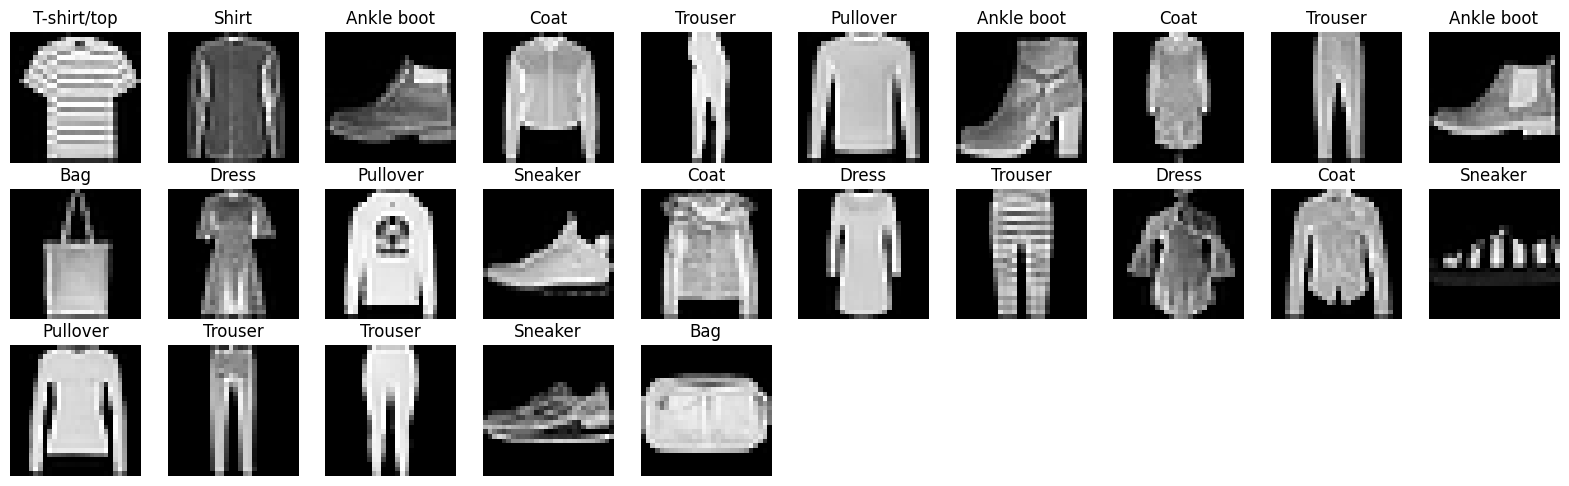

Coat: 6000
Ankle boot: 6000
Pullover: 6000
T-shirt/top: 6000
Sneaker: 6000
Dress: 6000
Shirt: 6000
Trouser: 6000
Bag: 6000
Sandal: 6000


In [4]:
# 데이터를 시각화하고 분석합니다.
explore_data(train_loader)

In [5]:
# CNN 모델을 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # 입력 채널 1, 출력 채널 6, 필터 크기 5
        self.pool = nn.MaxPool2d(2, 2)  # 풀링 크기 2x2
        self.conv2 = nn.Conv2d(6, 16, 5)  # 입력 채널 6, 출력 채널 16, 필터 크기 5
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 16개의 맵에서 4x4 크기, Fully Connected Layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
#x를 통해서 순전파를 수행하는 역할을 한다.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #첫 번째 컨볼루션 레이어를 통과시켜 출력을 생성
        x = self.pool(F.relu(self.conv2(x)))  #두 번째 컨볼루션 레이어를 통과시켜 출력을 생성
        x = x.view(-1, 16 * 4 * 4)  # Flatten
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결레이어를 통과 후 relu함수를 거쳐 출력생성
        x = F.relu(self.fc2(x))  # 첫 번째 완전 연결레이어를 통과 후 relu함수를 거쳐 출력생성
        x = self.fc3(x)  # 세 번째 Fully Connected Layer
        return x

In [6]:
# 모델을 초기화하고, 요약 정보를 출력한다.
net = SimpleCNN()
summary(net, input_size=(1, 28, 28))#summary를 import했기 때문에 사용 가능

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [6, 24, 24]               156
├─MaxPool2d: 1-2                         [6, 12, 12]               --
├─Conv2d: 1-3                            [16, 8, 8]                2,416
├─MaxPool2d: 1-4                         [16, 4, 4]                --
├─Linear: 1-5                            [1, 120]                  30,840
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 10]                   850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
Total mult-adds (M): 0.37
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.18
Estimated Total Size (MB): 0.22

In [7]:
# 손실 함수와 최적화 알고리즘을 선택한다.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [8]:
# 모델을 훈련한다.
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    # GPU 사용 가능 여부를 확인하고, 가능하면 GPU로 모델을 이동한다.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 훈련 및 테스트 결과를 저장할 리스트를 초기화한다.
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []
    
    # 주어진 에폭 수만큼 반복한다.
    for epoch in range(epochs):
        # 모델을 훈련 모드로 설정한다.
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        
        # 훈련 데이터셋에 대해 반복
        for data, target in train_loader:
            # 데이터와 타겟을 GPU로 이동
            data, target = data.to(device), target.to(device)
            # 그래디언트를 0으로 초기화
            optimizer.zero_grad()
            # 순전파를 진행
            output = model(data)
            # 손실을 계산
            loss = criterion(output, target)
            # 역전파를 수행하고 매개변수를 업데이트
            loss.backward()
            optimizer.step()
            # 훈련 손실을 누적
            train_loss += loss.item()
            # 정확한 예측 수를 계산
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
        
        # 훈련 손실을 전체 데이터셋 크기로 나누어 평균을 구한다.
        train_loss /= len(train_loader.dataset)
        # 훈련 정확도를 계산
        train_accuracy = 100 * correct_train / total_train
        # 훈련 손실과 정확도를 리스트에 추가
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
        
        # 모델을 평가 모드로 전환
        model.eval()
        test_loss, correct_test, total_test = 0, 0, 0
        with torch.no_grad():
            # 테스트 데이터셋에 대해 반복
            for data, target in test_loader:
                # 데이터와 타겟을 GPU로 이동
                data, target = data.to(device), target.to(device)
                # 순전파를 진행
                output = model(data)
                # 손실을 계산
                loss = criterion(output, target)
                # 테스트 손실을 누적
                test_loss += loss.item()
                # 정확한 예측 수를 계산
                _, predicted = torch.max(output.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()
                
        # 테스트 손실을 전체 데이터셋 크기로 나누어 평균을 구한다.
        test_loss /= len(test_loader.dataset)
        # 테스트 정확도를 계산
        test_accuracy = 100 * correct_test / total_test
        # 테스트 손실과 정확도를 리스트에 추가
        test_loss_history.append(test_loss)
        test_acc_history.append(test_accuracy)
        
        # 에폭마다 훈련 및 테스트 결과를 출력
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    return train_loss_history, train_acc_history, test_loss_history, test_acc_history

# train_model 함수를 호출하여 모델을 훈련
train_loss_history, train_acc_history, test_loss_history, test_acc_history = train_model(net, train_loader, test_loader, criterion, optimizer)

Epoch 1/5, Train Loss: 0.0097, Train Accuracy: 76.96%, Test Loss: 0.0071, Test Accuracy: 83.73%
Epoch 2/5, Train Loss: 0.0061, Train Accuracy: 85.54%, Test Loss: 0.0061, Test Accuracy: 85.78%
Epoch 3/5, Train Loss: 0.0053, Train Accuracy: 87.63%, Test Loss: 0.0054, Test Accuracy: 87.13%
Epoch 4/5, Train Loss: 0.0048, Train Accuracy: 88.55%, Test Loss: 0.0051, Test Accuracy: 88.06%
Epoch 5/5, Train Loss: 0.0045, Train Accuracy: 89.24%, Test Loss: 0.0054, Test Accuracy: 87.40%


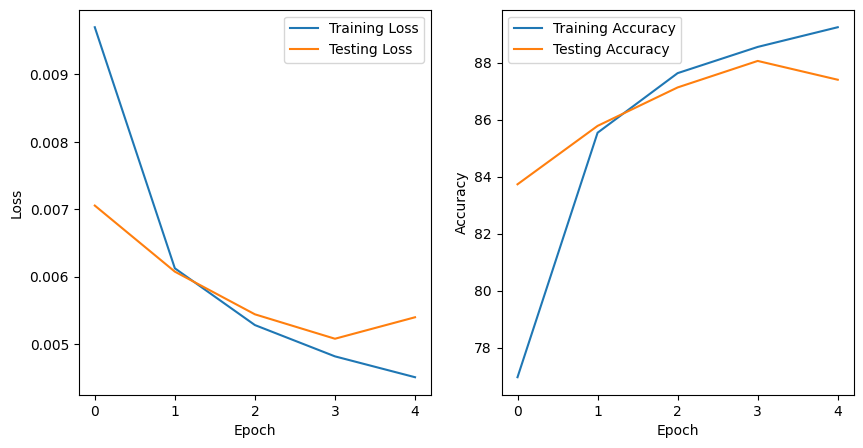

In [9]:
# 훈련 과정에서의 손실과 정확도를 시각화
plt.figure(figsize=(10, 5))

# 훈련 및 테스트 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')  # 훈련 손실 그래프
plt.plot(test_loss_history, label='Testing Loss')    # 테스트 손실 그래프
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 테스트 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')   # 훈련 정확도 그래프
plt.plot(test_acc_history, label='Testing Accuracy')     # 테스트 정확도 그래프
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()